In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

df = pd.read_csv("../data/time_series_60min_singleindex_filtered_DE_3features.csv")

## First look

In [14]:
#df = df / 1000
df.describe()

#486TWh pro Jahr


,DE_load_actual_entsoe_transparency,DE_solar_generation_actual,DE_wind_generation_actual
count,50400.000000,50297.000000,50326.000000
mean,55492.468552,4566.042905,11552.234650
std,10015.431042,6940.267590,9076.350769
min,31307.000000,0.000000,135.000000
25%,47106.000000,0.000000,4506.000000
50%,55092.000000,173.000000,9015.000000
75%,64309.250000,7342.000000,16113.750000
max,77549.000000,32947.000000,46064.000000


In [15]:
df.info()

# 50000 steps = 2000 days = 5 1/2 years


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50401 entries, 0 to 50400
Data columns (total 5 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   utc_timestamp                       50401 non-null  object 
 1   cet_cest_timestamp                  50401 non-null  object 
 2   DE_load_actual_entsoe_transparency  50400 non-null  float64
 3   DE_solar_generation_actual          50297 non-null  float64
 4   DE_wind_generation_actual           50326 non-null  float64
dtypes: float64(3), object(2)
memory usage: 1.9+ MB


In [16]:
df.head()

,utc_timestamp,cet_cest_timestamp,DE_load_actual_entsoe_transparency,DE_solar_generation_actual,DE_wind_generation_actual
0,2014-12-31T23:00:00Z,2015-01-01T00:00:00+0100,NaN,NaN,NaN
1,2015-01-01T00:00:00Z,2015-01-01T01:00:00+0100,41151.0,NaN,8852.0
2,2015-01-01T01:00:00Z,2015-01-01T02:00:00+0100,40135.0,NaN,9054.0
3,2015-01-01T02:00:00Z,2015-01-01T03:00:00+0100,39106.0,NaN,9070.0
4,2015-01-01T03:00:00Z,2015-01-01T04:00:00+0100,38765.0,NaN,9163.0


In [17]:


df = df.set_index(["utc_timestamp"])
df.index = pd.to_datetime(df.index)
#df.drop(columns="utc_timestamp")
df
print(df.iloc[[2]].index)


DatetimeIndex(['2015-01-01 01:00:00+00:00'], dtype='datetime64[ns, UTC]', name='utc_timestamp', freq=None)


## Cyclic features

In [18]:
df = df.drop(columns="cet_cest_timestamp")

 # Add time features
df["date"] = pd.to_datetime(df["utc_timestamp"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["dayofweek"] = df["date"].dt.dayofweek
df["hour"] = df["date"].dt.hour
# Make month and hour cyclic
# Need two dimensions (sin and cos) because only one would be ambgious (e.g. y=0.5 at two locations)
# period of sin(bx) or cos(bx) is p = 2*pi / b. We want p to be period of 12 (month), 7 (daysofweek) or 24(hours) respectively
df["month_sin"] = np.sin(2 * np.pi * df["month"]/12)
df["month_cos"] = np.cos(2 * np.pi * df["month"]/12)
#df = df.drop(columns="month")
df["dayofweek_sin"] = np.sin(2 * np.pi * df["dayofweek"]/7)
df["dayofweek_cos"] = np.cos(2 * np.pi * df["dayofweek"]/7)
#df = df.drop(columns="dayofweek")
df["hour_sin"] = np.sin(2 * np.pi * df["hour"]/24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"]/24)
#df = df.drop(columns="hour")


print(df[["dayofweek", "dayofweek_sin", "dayofweek_cos"]].groupby("dayofweek").mean())
print(df[["month", "month_sin", "month_cos"]].groupby("month").mean())
df.head(30)

KeyError: 'utc_timestamp'

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50401 entries, 0 to 50400
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype              
---  ------                              --------------  -----              
 0   utc_timestamp                       50401 non-null  object             
 1   DE_load_actual_entsoe_transparency  50400 non-null  float64            
 2   DE_solar_generation_actual          50297 non-null  float64            
 3   DE_wind_generation_actual           50326 non-null  float64            
 4   date                                50401 non-null  datetime64[ns, UTC]
 5   year                                50401 non-null  int32              
 6   month                               50401 non-null  int32              
 7   day                                 50401 non-null  int32              
 8   dayofweek                           50401 non-null  int32              
 9   hour                                504

## Autocorrelation and Partial Autocorrelation

ValueError: could not convert string to float: '2014-12-31T23:00:00Z'

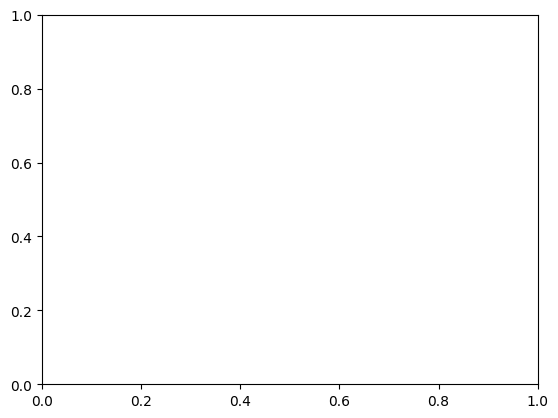

In [ ]:
number_of_lags = 24
lags = range(number_of_lags)
df_autocorr = pd.DataFrame(index=lags)
fig, ax = plt.subplots(1,1)

for column in df:
    df_autocorr[column] = [df[column].autocorr(lag=lag) for lag in lags]
    ax.plot(lags, df_autocorr[column], label=column)

ax.legend()
ax.set_xticks(range(0, number_of_lags, 12))
ax.grid(True)

plt.show()
# hourly data -> 24 step = 1 day

In [ ]:
import statsmodels.api as sm

fig, ax = plt.subplots(3,2, figsize=(14,10))

for i, column in enumerate(df):
    print(column)
    sm.graphics.tsa.plot_acf(df[column], lags=number_of_lags, ax=ax[i,0], missing="conservative")
    sm.graphics.tsa.plot_pacf(df[column], lags=number_of_lags, ax=ax[i,1])

plt.show()

In [ ]:
df.info()
print(len(df))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50401 entries, 2014-12-31 23:00:00+00:00 to 2020-09-30 23:00:00+00:00
Data columns (total 3 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   DE_load_actual_entsoe_transparency  50401 non-null  float64
 1   DE_solar_generation_actual          50401 non-null  float64
 2   DE_wind_generation_actual           50401 non-null  float64
dtypes: float64(3)
memory usage: 1.5 MB
50401


## Linear Regression